# Imports

In [1]:
import pandas as pd
import numpy as np
import os,  sys
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from mpl_toolkits import mplot3d

sys.path.append('/Users/benjaminwong/JupyterNotebooks/masters_pfti/notebooks/python/')

from hetanalysis import HetAnalysis
import plotter
from clean import PCBCCleaner, DrawPointAssayCleaner, DrawPointCoordCleaner

output_dir = "../outputs/het_analysis_compare_dp_pcbc/"
SAVE = False

plt.rcParams.update(
    {
        'font.size': 18
    }
)

# Data Input and Cleaning

In [2]:
pcbc_df = PCBCCleaner.get_processed_data()
dp_df = DrawPointAssayCleaner.get_processed_data()
dp_coords = DrawPointCoordCleaner.get_processed_data()

# Grouping

## PCBC

In [3]:
pcbc_dhids = list(pcbc_df['dhid'].unique())
len(pcbc_dhids)

398

In [4]:
elements = [
    'CU',
    'AU'
]

pcbc_groups = {}

for dhid in pcbc_dhids:
    filtered_df = pcbc_df.query('dhid == @dhid')
    pcbc_groups[dhid] = {}
    
    for element in elements:
        try:
            pcbc_groups[dhid][element] = HetAnalysis(f'{dhid}_{element}', filtered_df['weight'], filtered_df[element])
        except:
            print(f'Invalid data for {dhid}_{element}')

## DP Assays

In [5]:
dp_groups = {}
dp_dhids = dp_df['dhid'].unique()

invalid, valid = [], []

for dhid in dp_dhids:
    filtered_df = dp_df.query('dhid == @dhid')
    dp_groups[dhid] = {}
    
    for element in elements:
        try:
            dp_groups[dhid][element] = HetAnalysis(f'{dhid}_{element}', filtered_df['weight'], filtered_df[element])
            valid.append(f'{dhid}_{element}')
        except:
            invalid.append(f'{dhid}_{element}')

# Output

In [6]:
if SAVE:
    fig = plt.figure()
    fig.set_size_inches(10, 8)

    for dhid, pcbc_group in pcbc_groups.items():
        save_loc = output_dir + f'{dhid}/'
        if not os.path.exists(save_loc):
            os.makedirs(save_loc)

        for element in ['CU', 'AU']:
            if element in pcbc_group:
                fig.clear()
                ax = fig.add_subplot()
                ax_sec = ax.twinx()

                pcbc_het = pcbc_group[element].get_heterogeneity()
                dp_het = dp_groups[dhid][element].get_heterogeneity()
                
                pcbc_info = pcbc_group[element].get_info()
                dp_info = dp_groups[dhid][element].get_info()
                
                if len(pcbc_df) > 0:
                    title = f'{dhid}_{element}_PCBC={pcbc_het:.2f}_DP={dp_het:.2f}'
                    
                    ax.set_title(title.replace("_", " "))
                    
                    plotter.plot_g_r(ax, ax_sec, pcbc_info, alpha=0.2, ls='-')
                    plotter.scatter_g_r(ax, ax_sec, pcbc_info, marker='.', alpha=0.4)
                    
                    plotter.plot_g_r(ax, ax_sec, dp_info, ls='-')
                    plotter.scatter_g_r(ax, ax_sec, dp_info, marker='.')
                    
                    plotter.set_g_r_labels(ax, ax_sec, element)
                    
                    ax.grid()

                    fig.tight_layout()
                    fig.savefig(save_loc + title + '.svg', format='svg')

# Visualize

In [7]:
# Check if there is data not in the other group
for dpid in dp_groups:
    if dpid not in pcbc_groups:
        print(dpid)
for dpid in pcbc_groups:
    if dpid not in dp_groups:
        print(dpid)

In [8]:
delta_hs = {}

for dpid in list(dp_coords.index):
    if dpid not in dp_groups:
        for element in elements:
            if element not in delta_hs:
                delta_hs[element] = []
            delta_hs[element].append(np.nan)
    else:
        dp, pcbc = dp_groups[dpid], pcbc_groups[dpid]
        
        for element in elements:
            if element not in delta_hs:
                delta_hs[element] = []
                
            if element in dp:
                dp_h, pcbc_h = dp[element].get_heterogeneity(), pcbc[element].get_heterogeneity()
                delta_hs[element].append(dp_h - pcbc_h)
            else:
                delta_hs[element].append(np.nan)

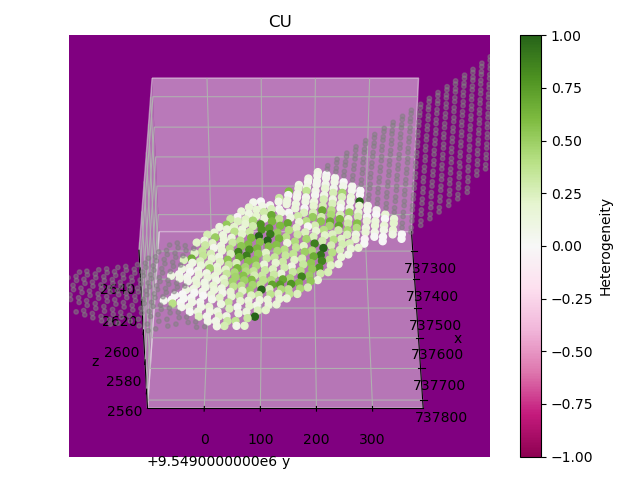

In [9]:
%matplotlib widget

fig = plt.figure()
ax = plt.axes(projection='3d')

element = 'CU'

delta_h = np.array(delta_hs[element])
x, y, z = dp_coords['x'], dp_coords['y'], dp_coords['z']

cmap = plt.colormaps.get('PiYG')

p = ax.scatter3D(
    x, 
    y,
    z, 
    c=delta_h,
    vmax=1,
    vmin=-1,
    cmap=cmap,
    s=25,
    alpha=1
)

# Set limits to the non-nan values
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.set_zlim([2550, 2650])


nan = np.argwhere(np.isnan(delta_h))
nan = nan.flatten()
ax.scatter3D(
    x[nan], 
    y[nan], 
    z[nan],
    s=10,
    alpha=0.5,
    c='grey'
)

ax.set_title(element)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_facecolor('purple')

cbar = fig.colorbar(p)
cbar.set_label('Heterogeneity')

ax.azim = 0
ax.elev = 40

fig.tight_layout()

In [10]:
delta_hs = {}

for dpid in list(dp_coords.index):
    if dpid not in dp_groups:
        for element in elements:
            if element not in delta_hs:
                delta_hs[element] = []
            delta_hs[element].append(np.nan)
    else:
        dp, pcbc = dp_groups[dpid], pcbc_groups[dpid]
        
        for element in elements:
            if element not in delta_hs:
                delta_hs[element] = []
                
            if element in dp:
                dp_h, pcbc_h = dp[element].get_heterogeneity(), pcbc[element].get_heterogeneity()
                if pcbc_h == 0.0:
                    delta = 1 if dp_h == 0.0 else 0
                else:
                    delta = dp_h / pcbc_h
                    
                delta_hs[element].append(delta)
            else:
                delta_hs[element].append(np.nan)

/var/folders/_x/r7wxfm355p1dqy5lc636rn240000gn/T/ipykernel_22587/449815562.py:16: RuntimeWarning: divide by zero encountered in log
  c=np.log(delta_h),


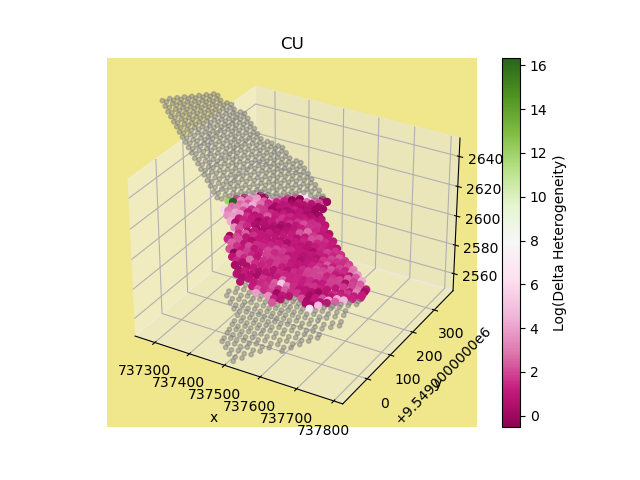

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')

element = 'CU'

delta_h = np.array(delta_hs[element])
x, y, z = dp_coords['x'], dp_coords['y'], dp_coords['z']

cmap = plt.colormaps.get('PiYG')
ax.set_facecolor('khaki')

p = ax.scatter3D(
    x, 
    y,
    z, 
    c=np.log(delta_h),
    # norm=colors.LogNorm(vmin=1e-1, vmax=1e1),
    cmap=cmap,
    s=25,
    alpha=1
)
# Set limits to the non-nan values
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.set_zlim([2550, 2650])


nan = np.argwhere(np.isnan(delta_h))
nan = nan.flatten()
ax.scatter3D(
    x[nan], 
    y[nan], 
    z[nan],
    s=10,
    alpha=0.5,
    c='grey'
)

ax.set_title(element)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

cbar = fig.colorbar(p)
cbar.set_label('Log(Delta Heterogeneity)')

In [12]:
delta_hs = {}

x, y = [], []

for dpid in list(dp_coords.index):
    if dpid not in dp_groups:
        for element in elements:
            if element not in delta_hs:
                delta_hs[element] = []
            delta_hs[element].append(np.nan)
    else:
        dp, pcbc = dp_groups[dpid], pcbc_groups[dpid]
        
        for element in elements:
            if element not in delta_hs:
                delta_hs[element] = []
                
            if element in dp:
                dp_h, pcbc_h = dp[element].get_grade(), pcbc[element].get_grade()
                
                x.append(dp_h)
                y.append(pcbc_h)
                
                delta_hs[element].append(dp_h - pcbc_h)
            else:
                delta_hs[element].append(np.nan)

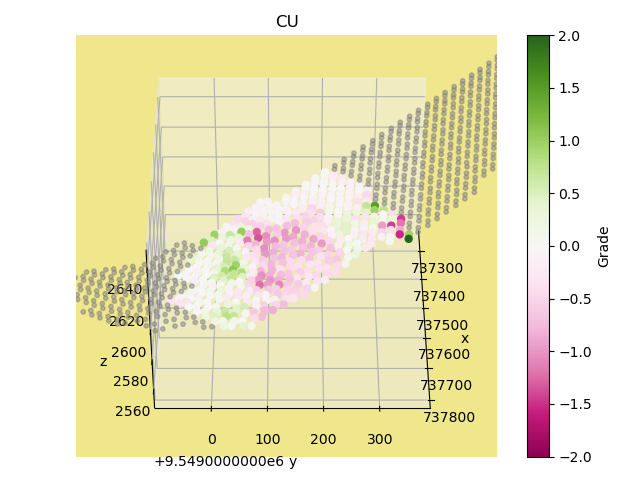

In [13]:
%matplotlib widget

fig = plt.figure()
ax = plt.axes(projection='3d')

element = 'CU'

delta_h = np.array(delta_hs[element])
x, y, z = dp_coords['x'], dp_coords['y'], dp_coords['z']

cmap = plt.colormaps.get('PiYG')

p = ax.scatter3D(
    x, 
    y,
    z, 
    c=delta_h,
    vmax=2,
    vmin=-2,
    cmap=cmap,
    s=25,
    alpha=1
)

# Set limits to the non-nan values
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.set_zlim([2550, 2650])


nan = np.argwhere(np.isnan(delta_h))
nan = nan.flatten()
ax.scatter3D(
    x[nan], 
    y[nan], 
    z[nan],
    s=10,
    alpha=0.5,
    c='grey'
)

ax.set_title(element)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_facecolor('khaki')

cbar = fig.colorbar(p)
cbar.set_label('Grade')

ax.azim = 0
ax.elev = 40

fig.tight_layout()

(array([ 3.,  1.,  3.,  5., 11., 15., 21., 27., 34., 32., 36., 80., 53.,
        19., 19., 13.,  4.,  9.,  4.,  4.,  3.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-1.54334811, -1.41565831, -1.28796851, -1.16027871, -1.03258891,
        -0.90489911, -0.7772093 , -0.6495195 , -0.5218297 , -0.3941399 ,
        -0.2664501 , -0.1387603 , -0.0110705 ,  0.1166193 ,  0.2443091 ,
         0.37199891,  0.49968871,  0.62737851,  0.75506831,  0.88275811,
         1.01044791,  1.13813771,  1.26582751,  1.39351732,  1.52120712,
         1.64889692,  1.77658672,  1.90427652,  2.03196632,  2.15965612,
         2.28734592]),
 <BarContainer object of 30 artists>)

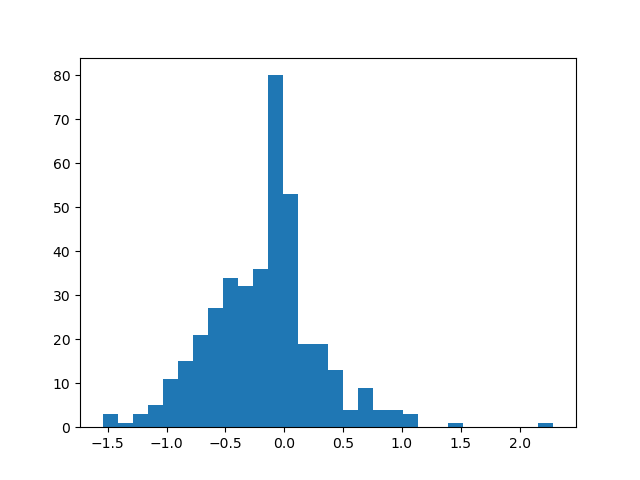

In [14]:
arr = pd.Series(delta_hs['CU'])

fig = plt.figure()
ax = fig.add_subplot()
ax.hist(arr, bins=30)

In [15]:
np.mean(y)

9549157.40806293

In [16]:
np.mean(x)

737283.4631882989